In [1]:
import time
import os
import glob
import cv2
import numpy as np

from keras.utils import np_utils
from keras.utils import to_categorical

import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.


<h1>Dataset</h1>

In [2]:
### paths to training and testing data
train_path = 'dataset/train'
test_path = 'dataset'

### other hyperparameters
n_folds = 2
batch_size = 16
nb_epoch = 50
bottleneck_epoch = 3  # used when training bottleneck model
val_split = .15  # if not using kfold cv
classes = ["dog", "cat"]
num_classes = len(classes)

### image dimensions
img_width, img_height = 224, 224

In [3]:
def load_images(path):
    img = cv2.imread(path)
    resized = cv2.resize(img, (img_width, img_height), cv2.INTER_LINEAR)
    return resized

In [4]:
def load_train():
    X_train = []
    X_train_id = []
    y_train = []
    start_time = time.time()

    print('Loading training images...')
    folders = ["dogs", "cats"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(train_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_train.append(img)
            X_train_id.append(flbase)
            y_train.append(index)

    print('Training data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_train, y_train, X_train_id

In [5]:
def load_test():
    X_test = []
    X_test_id = []
    y_test = []
    start_time = time.time()

    print('Loading test images...')
    folders = ["test"]
    for fld in folders:
        index = folders.index(fld)
        print('Loading {} files (Index: {})'.format(fld, index))
        path = os.path.join(test_path, fld, '*g')
        files = glob.glob(path)
        for fl in files:
            flbase = os.path.basename(fl)
            img = load_images(fl)
            X_test.append(img)
            X_test_id.append(flbase)
            y_test.append(index)

    print('Test data load time: {} seconds'.format(round(time.time() - start_time, 2)))
    return X_test, y_test, X_test_id

In [6]:
def normalize_train_data():
    train_data, train_target, train_id = load_train()

    train_data = np.array(train_data, dtype=np.uint8)
    train_target = np.array(train_target, dtype=np.uint8)

    #train_data = train_data.transpose((0, 3, 1, 2))

    train_data = train_data.astype('float32')
    train_data = train_data / 255
    #train_target = np_utils.to_categorical(train_target, num_classes)
    train_target = to_categorical(train_target, num_classes)

    print('Shape of training data:', train_data.shape)
    return train_data, train_target, train_id

In [7]:
def normalize_test_data():
    test_data, test_target, test_id = load_test()

    test_data = np.array(test_data, dtype=np.uint8)
    test_target = np.array(test_target, dtype=np.uint8)

    #test_data = test_data.transpose((0, 3, 1, 2))

    test_data = test_data.astype('float32')
    test_data = test_data / 255
    #test_target = np_utils.to_categorical(test_target, num_classes)
    test_target = to_categorical(test_target, num_classes)

    print('Shape of testing data:', test_data.shape)
    return test_data, test_target, test_id

In [8]:
x_train, y_train, train_id = normalize_train_data()

Loading training images...
Loading dogs files (Index: 0)
Loading cats files (Index: 1)
Training data load time: 14.32 seconds
Shape of training data: (6000, 224, 224, 3)


In [9]:
x_test, y_test, test_id = normalize_test_data()

Loading test images...
Loading test files (Index: 0)
Test data load time: 2.47 seconds
Shape of testing data: (1000, 224, 224, 3)


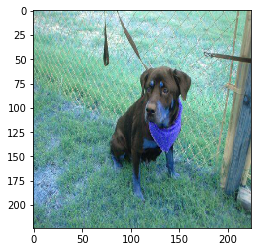

In [10]:
plt.imshow(x_train[2])

In [11]:
train_id[2]

'dog.11323.jpg'

In [12]:
y_train[0]

array([ 1.,  0.])

<h2>Criando uma CNN</h2>

In [13]:
from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras import optimizers
from keras.applications.resnet50 import ResNet50
#from keras import backend as K
#K.set_image_dim_ordering('th')

In [14]:
input_node = Input(shape=(img_width, img_height, 3))

conv_1 = Conv2D(filters=4, kernel_size=(3, 3), strides=1,
                activation='relu')(input_node)
pool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(filters=8, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_2)
conv_4 = Conv2D(filters=32, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_3)

flat = Flatten()(conv_4)

fc1 = Dense(2, activation='softmax')(flat)

model = Model(input_node, fc1)

In [14]:
# new
input_node = Input(shape=(img_width, img_height, 3))

conv_1 = Conv2D(filters=4, kernel_size=(3, 3), strides=1,
                activation='relu')(input_node)
pool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_1)

conv_2 = Conv2D(filters=8, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_1)
pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(filters=16, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_2)
conv_4 = Conv2D(filters=32, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_3)
conv_5 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_4)
conv_6 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_5)
conv_7 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_6)
conv_8 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_7)

flat = Flatten()(conv_8)

fc1 = Dense(2, activation='softmax')(flat)

model = Model(input_node, fc1)

In [15]:
input_node = Input(shape=(img_width, img_height, 3))

conv_1 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(input_node)
conv_2 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(conv_1)
conv_3 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(conv_2)
conv_4 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(conv_3)
conv_5 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(conv_4)
conv_6 = Conv2D(filters=64, kernel_size=(3, 3), strides=1,
                activation='relu')(conv_5)
pool_1 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_6)

conv_7 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_1)
conv_8 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_7)
conv_9 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_8)
conv_10 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_9)
conv_11 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_10)
conv_12 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_11)
conv_13 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_12)
conv_14 = Conv2D(filters=128, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_13)
pool_2 = MaxPooling2D(pool_size=(2, 2), strides=2)(conv_14)

conv_15 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(pool_2)
conv_16 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_15)
conv_17 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_16)
conv_18 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_17)
conv_19 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_18)
conv_20 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_19)
conv_21 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_20)
conv_22 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_21)
conv_23 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_22)
conv_24 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_23)
conv_25 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_24)
conv_26 = Conv2D(filters=256, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_25)

conv_27 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_26)
conv_28 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_27)
conv_29 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_28)
conv_30 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_29)
conv_31 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_30)
conv_32 = Conv2D(filters=512, kernel_size=(3, 3), strides=1,
               activation='relu')(conv_31)

flat = Flatten()(conv_32)

fc1 = Dense(num_classes, activation='softmax')(flat)

model = Model(input_node, fc1)

In [ ]:
def build_model():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    # compile the model with a SGD/momentum optimizer
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.SGD(lr=1e-4, momentum=0.9))
    return model

In [15]:
model = build_model()

NameError: name 'build_model' is not defined

In [14]:
model = ResNet50(include_top=True, 
                 weights=None, 
                 input_tensor=None, 
                 input_shape=None, 
                 pooling=None, classes=2)

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 4)       112       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 4)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 8)       296       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 8)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 52, 52, 16)        1168      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 50, 50, 32)        4640      
__________

In [16]:
model.fit(x_train, 
          y_train,
          batch_size=batch_size,
          nb_epoch=nb_epoch,
          shuffle=True,
          verbose=1,
          validation_data=(x_test, y_test))

/home/vagner/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


RuntimeError: You must compile a model before training/testing. Use `model.compile(optimizer, loss)`.

<h2>Expandindo dimensão das imagens</h2>

In [18]:
#x_train = np.expand_dims(x_train, axis=3)
#x_test = np.expand_dims(x_test, axis=3)

<h2>Compilando o modelo</h2>

In [16]:
from keras.optimizers import *
from keras.metrics import *

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', 
              metrics=['accuracy'])

In [18]:
# Parada antecipada, pois muitas vezes chutamos 
# um número de épocas muito grande e o modelo não precisa continuar treinando
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(min_delta=1e-3, monitor='val_loss', patience=3)

In [19]:
model.fit(x_train, 
          y_train, 
          batch_size=32, 
          epochs=10,
          callbacks=[early_stop],
          validation_data=(x_test, y_test))

Train on 6000 samples, validate on 1000 samples
Epoch 1/10
6000/6000 [==============================] - 1003s 167ms/step - loss: 8.0251 - acc: 0.4995 - val_loss: 16.1181 - val_acc: 0.0000e+00
Epoch 2/10
  96/6000 [..............................] - ETA: 16:20 - loss: 8.5627 - acc: 0.4688

KeyboardInterrupt: 

In [62]:
prediction = model.predict(x=x_test, batch_size=16, verbose=0, steps=None)
print(prediction)

[[ 0.36833632  0.63166374]
 [ 0.90519446  0.09480556]
 [ 0.71645331  0.28354672]
 ..., 
 [ 0.54641962  0.45358038]
 [ 0.41177672  0.58822334]
 [ 0.84833157  0.1516684 ]]


In [63]:
y_test[0]

array([ 1.,  0.])

In [64]:
prediction[0]

array([ 0.36833632,  0.63166374], dtype=float32)